# 【组合导航流程汇总】【NB24】Integrated_Navi.ipynb 

- 从【TEST】gnss-ins.ipynb中定义了运动路线后，生成轨迹，移动到gnss-ins文件夹
- 【NB16】BiNet_Matching_Iter.ipynb中进行匹配（最后），替换掉gps位置数据（速度vel数据暂时不能替换，因为速度估计不准确）
- 【TEST】LS_INS_GNSS.ipynb。再进行组合导航即可

## 定义运动与生成轨迹

In [1]:
import os
import math
import numpy as np

# x_direction = motion_pos_li[1][0] - motion_pos_li[0][0]
# y_direction = motion_pos_li[1][1] - motion_pos_li[0][1]
# yaw = np.rad2deg(math.atan2(y_direction,x_direction))
# # vel_li[0][1] = yaw
# print(yaw)

In [2]:
def get_vel_li_from_pos(pos_li, vel_avg):
    # 指定初始方位
    vel_li = [[  1,    0,    0,    0,    0,    0,    0,    0.1,    1] ]
#     vel_li = [[]]
#     vel_li = []
    # 计算朝向
#     x_direction = pos_li[1][0] - pos_li[0][0]
#     y_direction = pos_li[1][1] - pos_li[0][1]
#     yaw = np.rad2deg(math.atan2(y_direction,x_direction))
#     vel_li[0][1] = yaw
    # 遍历计算
    for i, pos_line in enumerate(pos_li):
        if i == 0 :
            continue
        #            type, yaw, pitch, roll,  vx[4], vy[5], vz[6] duration[7]  gps_vis 
        line_acc = [  5,    0,    0,    0,    0,      0,      0,      0,         1] # 空白
        line_sus = [  1,    0,    0,    0,    0,      0,      0,      0,         1] # 空白
        
        
        # 计算速度分量
        ratio = ((pos_li[i][0] - pos_li[i-1][0])) / ((pos_li[i][1] - pos_li[i-1][1]))
        vy = (vel_avg) / ((1+(ratio**2))**0.5)
        if pos_li[i][1] - pos_li[i-1][1] < 0:
            vy = -vy
        vx = ratio * vy
        
        # 计算时间
        dis = ((pos_li[i][0] - pos_li[i-1][0])**2 + (pos_li[i][1] - pos_li[i-1][1])**2)**0.5
        t = dis / vel_avg
        line_acc[4:8] = [vx, vy, 0, 1000]
        line_sus[7] = t
        vel_li.append(line_acc)
        vel_li.append(line_sus)
    return vel_li
# motion_vel_li = get_vel_li_from_pos(motion_pos_li, 10)

def offset_motion(motion_li, x_off, y_off):
    for i, line in enumerate(motion_li):
        motion_li[i][0] = motion_li[i][0] + x_off
        motion_li[i][1] = motion_li[i][1] + y_off
    return motion_li

In [3]:
# 定义运动
# import sys
# sys.path.append("..") 
from REF.LS_INS_GNSS_EKF.transform_functions import *
import math

# 写入【han】motion_def_2dline.csv来定义动作
name = "./REF/gnss-ins-sim/demo_motion_def_files/【han】motion_def_2dline.csv"
f = open(name, "w") # 每次写入都是覆盖

# 定义地图原点ori
lat_origin = np.deg2rad(28) # 中国东海位置
lon_origin = np.deg2rad(123.570504)
alt_origin = 0
print("地图原点坐标的NED表示 ： ", 0, 0, 0)
print("地图原点坐标的LLA表示 ： ", lat_origin, lon_origin, alt_origin)
# lat_ori, long_ori, alt_ori = NED_to_LLA_SE(0,0,0, lat_origin, lon_origin, alt_origin)

motion_pos_li = [
# x(North), y(East)
[  0, 0  ], 
[  50, 100  ], 
[ 150, 150  ], 
[ 200, 250  ], 
# [  300, 500  ],
]

# 平移系数
x_offset = 500
y_offset = 500
try:
    print("x_offset_outside = " + str(x_offset_outside))
    print("y_offset_outside = " + str(y_offset_outside))
except:
    print("外部变量未找到，使用【本地平移系数变量】")
else:
    x_offset = x_offset_outside
    y_offset = y_offset_outside
    print("外部变量存在，使用【外部平移系数变量】")
motion_pos_li = offset_motion(motion_pos_li, x_offset, y_offset)

# 定义运动列表
motion_vel_li = get_vel_li_from_pos(motion_pos_li, 10)
# motion_vel_li = [
# # type, yaw, pitch, roll,  vx,    vy,   vz  duration  gps_vis # 可自由加减行
# [  1,    0,    0,    0,    0,    0,    0,    1,    1], 
# [  2,    0,    0,    0,   0,  10,    0,    10,    1], 
# [  2,    0,    0,    0,   10,  0,    0,    10,    1], 
# ]


# 赋予初始速度（航位推算不关心姿态，故姿态参数都为0）
ini_vx_body = motion_vel_li[1][4]
ini_vy_body = motion_vel_li[1][5]
ini_vz_body = 0

# 定义出发点 ini,xyz
ini_x = motion_pos_li[0][0]
ini_y = motion_pos_li[0][1]
ini_z = 0
ini_lat, ini_lon, ini_alt = NED_to_LLA_SE(ini_x, ini_y, ini_z, lat_origin, lon_origin, alt_origin)
print("出发点坐标NED表示：      ", ini_x, ini_y, ini_z)
print("出发点坐标LLA表示：      ", ini_lat, ini_lon, ini_alt)

# 定义初始角度
# x_direction = motion_pos_li[1][0] - motion_pos_li[0][0]
# y_direction = motion_pos_li[1][1] - motion_pos_li[0][1]
# yaw = np.rad2deg(math.atan2(y_direction,x_direction))
# # vel_li[0][1] = yaw
# print(yaw)

ini_yaw = 0
ini_pitch = 0
ini_roll = 0


# 写入初始参数
f.write("ini lat (deg),ini lon (deg),ini alt (m),ini vx_body (m/s),ini vy_body (m/s),ini vz_body (m/s),ini yaw (deg),ini pitch (deg),ini roll (deg)\n")
f.write(str((np.rad2deg(ini_lat), np.rad2deg(ini_lon), ini_alt, ini_vx_body, ini_vy_body, ini_vz_body, ini_yaw, ini_pitch, ini_roll))[1:-1])
f.write("\n") 

# 写入连续指令
f.write("command type,yaw (deg),pitch (deg),roll (deg),vx_body (m/s),vy_body (m/s),vz_body (m/s),command duration (s),GPS visibility\n") 
for line in motion_vel_li:
#     print(line)
    f.write(str(line)[1:-1])
    f.write("\n") 

f.close()
print("\n ==========以下计算运动过程=============")

地图原点坐标的NED表示 ：  0 0 0
地图原点坐标的LLA表示 ：  0.4886921905584123 2.156712153148823 0
外部变量未找到，使用【本地平移系数变量】
出发点坐标NED表示：       500 500 0
出发点坐标LLA表示：       0.4887709354136777 2.1568008766542768 0.039270358363825496

 ==========以下计算运动过程=============


In [4]:
# 初始惯导偏差定义
## 从北东坐标的米转换为经纬高的差异
ins_north_bias = 00.0
ins_east_bias  = 30.0
lat_init_bia = np.deg2rad(ins_north_bias / 111e3)
lon_init_bia = np.deg2rad(ins_east_bias  / (111e3 * math.cos(lat_origin)))


------------------------------------------------------------
Sample frequency of IMU: [fs] = 100.0 Hz
Reference frame: 0
Simulation time duration: 30.11 s
Simulation runs: 1

------------------------------------------------------------
Simulation results are saved to /root/autodl-tmp/dino/test/REF/gnss-ins-sim/demo_saved_data/2023-10-23-14-22-32
The following results are saved:
	time: sample time
	ref_pos: true LLA pos in the navigation frame
	ref_vel: true vel in the NED frame
	ref_att_euler: true attitude (Euler angles, ZYX)
	ref_accel: true accel in the body frame
	ref_gyro: true angular velocity in the body frame
	gps_time: GPS sample time
	ref_gps: true GPS LLA position and NED velocity
	gps_visibility: GPS visibility
	accel: accel measurements
	gyro: gyro measurements
	gps: GPS LLA position and NED velocity measurements
	pos: simulation position from algo
	att_euler: simulation attitude (Euler, ZYX)  from algo
	vel: simulation velocity from algo
	ref_att_quat: true attitude (qua

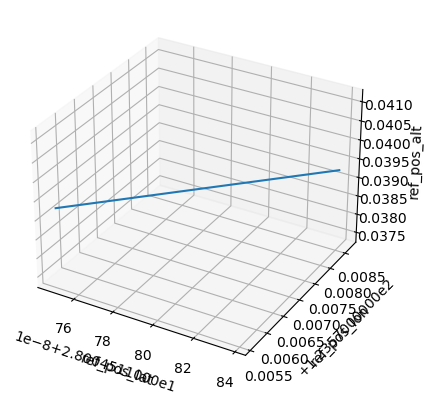

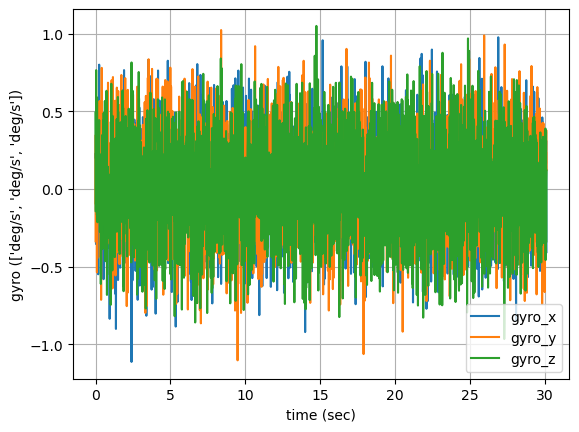

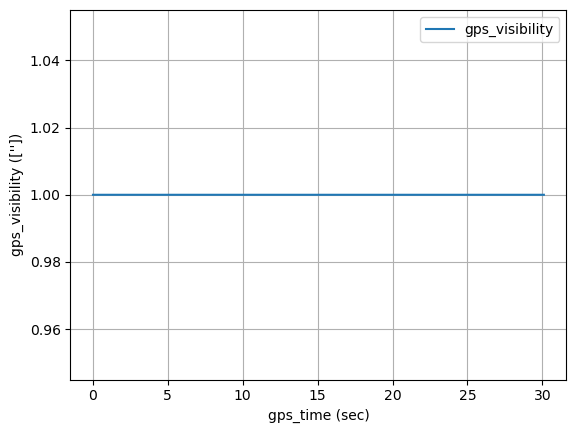

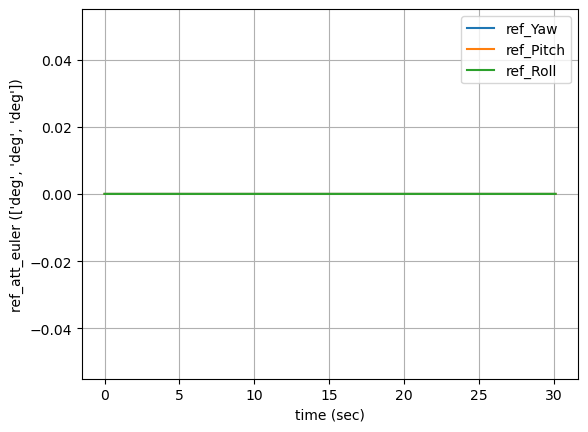

In [5]:
import os
path_ori = os.getcwd() # 保存原来的工作路径位置
os.chdir("/root/autodl-tmp/dino/test/REF/gnss-ins-sim/") # 切换到gnss-ins-sim的工作路径下
%run 【han】demo_han_free_integration.py # 在生成仿真的基础上做了纯惯性导航
# %run demo_no_algo.py # 生成仿真数据
os.chdir(path_ori)   # 切换回原来的工作路径

In [6]:
# 只生成数据
os.chdir("/root/autodl-tmp/dino/test/REF/gnss-ins-sim/") # 切换到gnss-ins-sim的工作路径下
exp_li = [name for name in os.listdir("./demo_saved_data/" ) if len(name)==19]
exp_li.sort()
instance_name = exp_li[-1]
print("Using Folder of Time: ", instance_name)

Using Folder of Time:  2023-10-23-14-22-32


In [7]:
# 搬运文件
import numpy as np
import math
# 运行后数据处理
# 主要关注：accel-0.csv、gps_time.csv、gps-0.csv、gyro-0.csv
# 以及时间：gps_time.csv、time.csv

# 合并时间、陀螺仪、加表
# instance_name = "2023-08-05-21-18-41" # 强制使用在此指定，如果注释则会按照时间找到最新的数据
gen_path = "./demo_saved_data/" + instance_name + "/"
time_imu = np.genfromtxt(gen_path + "time.csv", delimiter=',', skip_header=1)
gyro_data = np.genfromtxt(gen_path + "gyro-0.csv", delimiter=',', skip_header=1)
acc_data = np.genfromtxt(gen_path + "accel-0.csv", delimiter=',', skip_header=1)
imu_data = np.concatenate((np.expand_dims(time_imu, axis=1), gyro_data, acc_data), axis=1)
np.savetxt(gen_path + "imu.txt", imu_data, delimiter=',')

# 拆分GNSS数据并转换角度为弧度
gps_data = np.genfromtxt(gen_path + "gps-0.csv", delimiter=',', skip_header=1)
gps_data[:,0] = np.deg2rad(gps_data[:,0]) # 纬度lat转换为弧度
gps_data[:,1] = np.deg2rad(gps_data[:,1]) # 经度lon转换为弧度
# gps_data[:] = 0
# # gps_data[:,0] = np.deg2rad(gps_data[0,0])
# # gps_data[:,1] = np.deg2rad(gps_data[0,1])
# gps_data = np.zeros((39082,6))
# gps_data[:,0] = 0.78495171289626
# gps_data[:,1] = -1.62575144938045,
# gps_data[:,2] = 246.75244803726673
np.savetxt(gen_path + "gps_pos_lla.txt", gps_data[:,0:3], delimiter=',')
np.savetxt(gen_path + "gps_vel_ned.txt", gps_data[:,3:6], delimiter=',')

# 将参考、纯惯导结果转为NED并存储
data_ref = np.genfromtxt(gen_path+"/ref_gps.csv",delimiter=',', skip_header=1)
data_ref_NED = np.zeros_like(data_ref[:,0:3])
for i, line in enumerate(data_ref):
    data_ref_NED[i] = LLA_to_NED_SE(np.deg2rad(line[0]), np.deg2rad(line[1]), line[2], lat_origin, lon_origin, alt_origin)
np.savetxt(gen_path + "【NED】【参考位置】ref_gps_NED.csv", data_ref_NED, delimiter=',')
# 纯惯导
data_ins = np.genfromtxt(gen_path+"/pos-algo0_0.csv",delimiter=',', skip_header=1)
data_ins_NED = np.zeros_like(data_ins[:,0:3])
for i, line in enumerate(data_ins):
    data_ins_NED[i] = LLA_to_NED_SE(np.deg2rad(line[0]), np.deg2rad(line[1]), line[2], lat_origin, lon_origin, alt_origin)
np.savetxt(gen_path + "【NED】【纯惯导结果】pos-algo0_0.csv", data_ins_NED, delimiter=',')

# 纯惯导（有初始偏差）
data_ins = np.genfromtxt(gen_path+"/pos-algo0_0.csv",delimiter=',', skip_header=1)
data_ins_NED = np.zeros_like(data_ins[:,0:3])
for i, line in enumerate(data_ins):
    data_ins_NED[i] = LLA_to_NED_SE(np.deg2rad(line[0])+lat_init_bia, np.deg2rad(line[1])+lon_init_bia, line[2], lat_origin, lon_origin, alt_origin)
np.savetxt(gen_path + "【NED】【纯惯导结果】【加入初始偏差】pos-algo0_0.csv", data_ins_NED, delimiter=',')

# 移动到LS松组合导航文件夹下
import shutil
import os
try:
    dir_to_move = "../LS_INS_GNSS_EKF/data_han/" + instance_name + "/"
    os.mkdir(dir_to_move)
    print("创建成功", dir_to_move)
except:
    print("未创建成功:", dir_to_move)
shutil.copy(gen_path + "imu.txt", dir_to_move + "imu.txt")
shutil.copy(gen_path + "gps_pos_lla.txt", dir_to_move + "gps_pos_lla.txt")
shutil.copy(gen_path + "gps_vel_ned.txt", dir_to_move + "gps_vel_ned.txt")
shutil.copy(gen_path + "ref_gps.csv", dir_to_move + "ref_gps.csv")
shutil.copy(gen_path + "【NED】【参考位置】ref_gps_NED.csv", dir_to_move + "【NED】【参考位置】ref_gps_NED.csv")

try:
    shutil.copy(gen_path + "pos-algo0_0.csv", dir_to_move + "【纯惯导结果】pos-algo0_0.csv")
    shutil.copy(gen_path + "【NED】【纯惯导结果】pos-algo0_0.csv", dir_to_move + "【NED】【纯惯导结果】pos-algo0_0.csv")
    shutil.copy(gen_path + "【NED】【纯惯导结果】【加入初始偏差】pos-algo0_0.csv", dir_to_move + "【NED】【纯惯导结果】【加入初始偏差】pos-algo0_0.csv")
except:
    print("未发现算法生成的位置结果，跳过")
print("复制后新文件夹的文件：")
print(os.listdir(dir_to_move))
print("Done")
os.chdir(path_ori)   # 切换回原来的工作路径

/tmp/ipykernel_5987/19309305.py:35: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  data_ref_NED[i] = LLA_to_NED_SE(np.deg2rad(line[0]), np.deg2rad(line[1]), line[2], lat_origin, lon_origin, alt_origin)
/tmp/ipykernel_5987/19309305.py:41: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  data_ins_NED[i] = LLA_to_NED_SE(np.deg2rad(line[0]), np.deg2rad(line[1]), line[2], lat_origin, lon_origin, alt_origin)


创建成功 ../LS_INS_GNSS_EKF/data_han/2023-10-23-14-22-32/
复制后新文件夹的文件：
['imu.txt', 'gps_pos_lla.txt', 'gps_vel_ned.txt', 'ref_gps.csv', '【NED】【参考位置】ref_gps_NED.csv', '【纯惯导结果】pos-algo0_0.csv', '【NED】【纯惯导结果】pos-algo0_0.csv', '【NED】【纯惯导结果】【加入初始偏差】pos-algo0_0.csv']
Done


/tmp/ipykernel_5987/19309305.py:48: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  data_ins_NED[i] = LLA_to_NED_SE(np.deg2rad(line[0])+lat_init_bia, np.deg2rad(line[1])+lon_init_bia, line[2], lat_origin, lon_origin, alt_origin)


## 按轨迹进行匹配，输出匹配位置

In [8]:
from Py01shared_code import AddPepperNoise, AddGaussianNoise, get_host_name_DINO_X, AddGaussianNoise_Pre_Snr, AddGaussianNoise_Pre, AddGaussianNoise_snr
from Py04Model_load import load_Pre_ViT_No1, get_args , dataset_from_geoTXT
from Py05_Matching_fun import idx2xy, xy2idx, idx_ex_range , dataset_from_geoTXT_aug_BiNorm, dataset_from_geoTXT_aug_BiNorm_BiAug, dataset_from_geoTXT_aug_BiNorm_BiAug_crop_and_padding, feature_normalize, minmaxscaler
from Py05_Matching_fun import dataset_from_geoTXT_aug_BiNorm_BiAug_Norm_first_then_mask, dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug, dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug_noIMG, dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug_noIMG_Resize
from Py06BiNet import load_Pre_BiNet_No1, get_global_norm, get_local_aug, load_Pre_BiNet_Res_NO1
from Py07EEnT import load_Pre_EEnT_tiny_No1
from Py08EEnT_NO2 import EEnT_NO2_tiny, load_Pre_EEnT_NO2_tiny
import Py10Bi_model
from Py11_Aug_self import MuskApply, MuskApply_tensor

In [9]:
import torch
import utils
import torch.distributed as dist
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms as pth_transforms
import numpy as np
import math

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import sys
import time

import random
import datetime

In [10]:
# 定义裁剪形状和步长
shape = (224, 224)
crop_shape = (224, 224)
# out_shape = (224, 224)
stride = 1
mask_size = 20 # 224
pad_mode = "constant" # constant 为0填充、‘mean’——表示均值填充、‘median’——表示中位数


In [11]:
stride_test = 20
rand_test_num = 1000

In [12]:
# 若对应不上编码的Matching_fea文件，可在下方手动指定save_file_path
t_prefix = datetime.date.today().strftime('%Y%m%d')
t_prefix = "20230625"
map_name = "大西洋4.txt" # test5.txt
# map_name = "大连海图数据.txt"
save_dir = "./Matching_fea/"
net_name = "【BiNet_Res_NO1】" + "_"
# mask_info = "mask_size" + str(mask_size) + "_"
mask_info = ""
addtion_info = "" +  "consPad" + "_"
host_name = get_host_name_DINO_X()

output_name = t_prefix + map_name[0:-4] + net_name + mask_info +  "fea_" + addtion_info + host_name + ".pth"# "-shape" # + str(shape[0]) + "stride" + str(stride) +  ".pth"
save_file_path = save_dir + output_name
load_grid = True # 是否读取划分好的网格节省时间
map_grid_path = "./Matching_map_raw/" + map_name[0:-4] + "_gridsize1.pth"
print(save_file_path)

./Matching_fea/20230625大西洋4【BiNet_Res_NO1】_fea_consPad_DINO_3.pth


In [13]:
# save_file_path = "./Matching_fea/20230811test5grid_1【GRET_ELE_DB_NO2_bi】_tempfea_consPad_crop_shape_224DINO_7.pth"
save_file_path = "./Matching_fea/20231020大西洋4grid_1【GRET_ELE_DB_NO2_bi】_tempfea_mask_size_20DINO_6.pth"
ex_range = 50# 匹配用的先验范围

args_self=[
# "--data_path","./Data_geo/Matching_test_high80/匹配test-high80",
# '--box_label_path',"./Data_geo/Matching_test_high80/【Label】匹配test-high80.csv",
# "--load_features","./dump_features", # 注释与否决定是否从文件加载特征
"--pretrained_weights", "./【checkpoint存档】/20230728【GRET_ELE_DB_NO2_bi】DINO_7_01.pth",
# "--pretrained_weights", "./checkpoint.pth",
# "--arch", "BiNet_NO1",
"--arch", "GRET_ELE_DB_NO2_bi", # 可选 BiNet_NO1、EEnT_tiny_NO1、EEnT_tiny_NO2, BiNet_Res_NO1, TBiNet_Res_NO2_bi
'--num_ele_slice', "20000",
]

args = get_args(args_self)


### 参数替换

* 如果从外部运行，且使用了其命名空间，可以通过检查某些变量是否存在来判断，是直接运行还是从外部运行

In [14]:
try:
    print("\r\n尝试读取外部变量：")
    print("pre_model_path_outside = " + str(pre_model_path_outside)) # 预训练权重
    print("net_name_outside = " + str(net_name_outside)) # 网络名称
    print("arch_outside = " + str(arch_outside))
    print("save_file_path_outside = " + str(save_file_path_outside))
    print("map_grid_path_outside = " + str(map_grid_path_outside))
    print("shape_outside = " + str(shape_outside))
    print("stride_test_outside = " + str(stride_test_outside))
    print("crop_shape_outside = " + str(crop_shape_outside))
    print("ex_range_outside = " + str(ex_range_outside))
    print("num_ele_slice_outside = ", num_ele_slice_outside)
except NameError: # 外部定义变量不存在，使用本地，do noting
    print("外部变量不存在，使用【本地变量】")
#     var_exists = False
else: # 外部变量存在，使用外部：替换
    print("外部变量存在，使用【外部配置】")
    args.pretrained_weights = pre_model_path_outside
    args.arch = arch_outside
    net_name = net_name_outside
    save_file_path = save_file_path_outside
    map_grid_path = map_grid_path_outside
    shape = shape_outside
    stride_test = stride_test_outside
    crop_shape = crop_shape_outside
    ex_range = ex_range_outside
    mask_size = mask_size_outside
    pad_mode = pad_mode_outside
    args.num_ele_slice = num_ele_slice_outside
#     var_exists = True


尝试读取外部变量：
外部变量不存在，使用【本地变量】


### 载入网格

In [15]:
x,y,z = torch.load(map_grid_path)
print("已存储网格载入成功")
# 定义裁剪形状和步长
global_min = z.min()
global_max = z.max()



已存储网格载入成功


In [16]:
n_rows = (z.shape[0] - shape[0]) // stride + 1
n_cols = (z.shape[1] - shape[1]) // stride + 1
n_matrices = n_rows * n_cols
# n_rows + 112
print(str((n_rows, n_cols, n_matrices)))

(1775, 1775, 3150625)


In [17]:
per_li = []
# for i in range(args.num_ele_slice):
#     per_test = np.percentile(z, 100 / args.num_ele_slice * (i + 1))
#     per_test = (per_test - global_min) / (global_max - global_min)
#     per_li.append(per_test)
per_li = np.percentile(z, np.linspace(0,100, args.num_ele_slice))
per_li = (per_li - global_min) / (global_max - global_min)
per_li[-1] = 1
print("已读取分位数列表：per_li， 份数" + str(args.num_ele_slice) )
# print(per_li)

已读取分位数列表：per_li， 份数20000


In [18]:
per_li_var = []
# for i in range(args.num_ele_slice):
#     per_test = np.percentile(z, 100 / args.num_ele_slice * (i + 1))
#     per_test = (per_test - global_min) / (global_max - global_min)
#     per_li_var.append(per_test)
per_li_var = np.percentile(z, np.linspace(0,100, args.num_ele_slice))
per_li_var = (per_li_var - global_min) / (global_max - global_min)
per_li_var[-1] = 1
print("已读取分位数列表：per_li_var， 份数" + str(args.num_ele_slice) )
# print(per_li)

已读取分位数列表：per_li_var， 份数20000


### 加载预存储的特征向量

In [ ]:
%%time
fea_vec_li = torch.load(save_file_path)
print("【预存储特征加载完成】\n嵌入维度为 " + str(fea_vec_li.shape[1]) +  "\n向量个数为：" + str(fea_vec_li.shape[0]))

In [ ]:
try:
    utils.init_distributed_mode(args)
except:
    print("已经启动，不再重复")
    pass

### 数据集加载

In [ ]:
transform_for_match = pth_transforms.Compose([
    
#     AddGaussianNoise_snr(mean=0, variance=1, snr=( 1 - 0.04)),
#         AddGaussianNoise(mean=0, variance=1, amplitude=255),
    AddGaussianNoise(mean=0, variance=5, amplitude=1),
    AddPepperNoise(snr = 0.999, p = 1.0),
    pth_transforms.RandomRotation((0, 2), expand=False), # Rotation先，出来的图是正的
    MuskApply(mask_size = mask_size, mode = pad_mode), # constant为0填充、‘mean’——表示均值填充、‘median’——表示中位数
#     pth_transforms.RandomRotation((0, 10), expand=False), # Rotation后，出来的图是有斜角的
#     pth_transforms.Resize([224,224]),
    
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(mean=[0.485], std=[0.229]),
])

transform_for_global_match = pth_transforms.Compose([
#     MuskApply(mask_size = mask_size, mode=pad_mode),
    pth_transforms.CenterCrop(mask_size),
    pth_transforms.ToTensor(),
])
dataset_geo = dataset_from_geoTXT_aug_BiNorm_BiAug(z, shape, stride, transform_for_match, transform_for_global_match, global_min, global_max)

In [ ]:
data,data_global_norm,_,_ = dataset_geo.__getitem__(1000)
plt.imshow(data.squeeze())
plt.show()
plt.imshow(data_global_norm.squeeze())
plt.show()
print(data.shape)
print(data_global_norm.shape)
print("普通归一化与全局归一化图像")

In [ ]:
# 全局归一化
# def get_global_norm(data):
#     data_global_norm = (data - global_min) / (global_max - global_min)
#     # 给左上角与右下角赋值，便于观察最大最小（实际输入网络不需要这一步）
#     data_global_norm[0] = 0
#     data_global_norm[-1]  = 1
#     return data_global_norm

# 给左上角与右下角赋值，便于观察最大最小（实际输入网络不需要这一步）
data_global_norm[0] = 0
data_global_norm[-1]  = 1
plt.imshow(data_global_norm.squeeze())
print("全局归一化图像")

In [ ]:
# 获取bof特征
load_bof_voc = True
if load_bof_voc:
    bof_voc, bof_stdSlr = torch.load("./bof_voc/voc_Pacific.pth")
    voc_k = bof_voc.shape[0]
    print("voc_k = ", voc_k, " (代表sift_bof特征维度为此值，后续的嵌入会沿用这一切分维度)")
    print("成功加载bof_voc")
else:
    voc_k = 100
    bof_voc, bof_stdSlr = get_bof_Pacific_voc(dataset_geo, using_num = 2000, voc_k = voc_k)
    torch.save((bof_voc, bof_stdSlr), "./bof_voc/voc_Pacific.pth")

### 加载预训练模型

* 注意，这里加载的预训练模型需要与编码预存储的一致，例如使用【Try4】预训练模型

In [ ]:
%%time
assert os.path.exists(args.pretrained_weights), "权重不存在，检查路径"

if args.arch == "BiNet_NO1":
    model = load_Pre_BiNet_No1(args)
elif args.arch == "EEnT_tiny_NO1": 
    model = load_Pre_EEnT_tiny_No1(args)
elif args.arch == "EEnT_tiny_NO2":
    model = load_Pre_EEnT_NO2_tiny(args, per_li = per_li)
    embed_dim = model.embed_dim
elif args.arch == "BiNet_Res_NO1":
    model = load_Pre_BiNet_Res_NO1(args)
    embed_dim = model.embed_dim
elif args.arch in Py10Bi_model.__dict__.keys():
    try:
        model = Py10Bi_model.__dict__[args.arch]() # 调用函数
        print("模型" + args.arch + "创建成功")
        Py10Bi_model.load_Pre_type1(model, args)
        print("预训练模型加载成功")
    except:
        model = Py10Bi_model.__dict__[args.arch](num_ele_slice=args.num_ele_slice, per_li=per_li, per_li_var=per_li_var,
                                           bof_voc=bof_voc, bof_stdSlr=bof_stdSlr, in_chans=1, voc_k = voc_k,
                                          g_min = global_min, g_max = global_max)
        embed_dim = model.embed_dim
        Py10Bi_model.load_Pre_type1(model, args)
        print("预训练模型加载成功")
else:
    assert 0, "不支持的模型"
    
# utils.init_distributed_mode(args)
print("【完成】使用预训练模型：" + str(args.pretrained_weights))
print("【完成】计算节点(process group)启动完成")

### 单个点遍历匹配测试

In [ ]:
def matching_iter(output_vec, search_range_li):
    pre_index = -1
    min_dis = 100000
    pdist = torch.nn.PairwiseDistance(p=2)
#     pdist = DINOLoss_for_Matching(out_dim = 192).cuda()

    for i in search_range_li:
        dis = pdist(output_vec, fea_vec_li[i, :].unsqueeze(0))
#         similarity = torch.cosine_similarity(output_vec.squeeze(), fea_vec_li[i, :], dim=0)
        if dis < min_dis:
            min_dis = dis
            pre_index = i
    return pre_index, min_dis

In [ ]:
def distance_point(box1, box2):
    x_dis = math.pow((box1[0] - box2[0]), 2)
    y_dis = math.pow((box1[1] - box2[1]), 2)
    return math.sqrt(x_dis + y_dis)

In [ ]:
# %%time
rand_idx = int(torch.rand([1], dtype=torch.float32) * len(dataset_geo))
# rand_idx = 5872663
print("测试序号:" + str(rand_idx))

data, data_global_norm, index, box =  dataset_geo.__getitem__(rand_idx)
# samples = samples.unsqueeze(0).cuda()
# data_global_norm = get_global_norm(samples)
# data = get_local_aug(samples)
data = data.unsqueeze(0).cuda(non_blocking=True)
data_global_norm = data_global_norm.unsqueeze(0).cuda(non_blocking=True)
output_vec = model(data, data_global_norm)
print("输出向量尺寸：" + str(output_vec.shape))

range_li = idx_ex_range(index, ex_range, n_rows, n_cols)
len(range_li)

pre_index, min_dis = matching_iter(output_vec, range_li)

# 计算像素偏差
center_Truth = idx2xy(index, n_rows, n_cols)
center_Pred  = idx2xy(pre_index, n_rows, n_cols)
grid_bias = distance_point(center_Truth, center_Pred)

print("匹配预测id为： " + str(pre_index))
print("真实标签id为： " + str(int(index)))
print("最小特征距离为：" + "{:.3f}".format(float(min_dis))) 
print("网格偏差距离：" + "{:.3f}".format(grid_bias))

In [ ]:
import numpy as np
from REF.LS_INS_GNSS_EKF.transform_functions import *

# 读取轨迹，转换为网格
# trajectory_path = "./REF/LS_INS_GNSS_EKF/data_han/2023-08-05-21-18-41/"
trajectory_path = "./REF/LS_INS_GNSS_EKF/data_han/" + instance_name + "/"
print("============使用轨迹文件路径：", trajectory_path, "============")
gps_data = np.genfromtxt(trajectory_path + "ref_gps.csv", delimiter=',', skip_header=1)
meter_per_grid = 1# 定义1m是几个网格

# lat_origin = np.deg2rad(28) # 中国东海位置，此处参数需要与轨迹保持一致
# lon_origin = np.deg2rad(123.570504)
# alt_origin = -100

NED_pos = np.zeros_like(gps_data[:, 0:3])
for i in range(gps_data.shape[0]):
    north, east, down = LLA_to_NED_SE(np.deg2rad(gps_data[i, 0]), np.deg2rad(gps_data[i, 1]), gps_data[i, 2], lat_origin, lon_origin, alt_origin)
    NED_pos[i] = north, east, down

# 
NED_pos_grid = np.around(NED_pos/meter_per_grid) # 根据尺度换算
NED_pos_grid_uni = np.unique(NED_pos_grid, axis=0).astype(int) # 去重，方便遍历匹配

In [ ]:
def print_result(file = sys.stdout):
    print("总时长: " + str(total_time) + " s", file = file)
    print("测试时的增强："+ str(transform_for_match), file = file)
    try:
        print(Gauss_aug_Obj, file = file)
    except:
        pass
    print("测试地图：" + str(map_grid_path), file = file)
    print("随机测试数量：" + str(rand_test_num), file = file)
    print("crop_shape：" + str(crop_shape), file = file)
#     print("输入尺寸（网络）：" + str(out_shape), file = file)
    print("地图尺寸：" + str(z.shape), file = file)
#     print("测试数量：" + str(n_rows_test) + "*" + str(n_cols_test) + " = " + str(n_matrices_test), file = file)
#     print("步长stride_test  =" + str(stride_test), file = file)
    print("save_file_path = " + str(save_file_path), file = file)
    print("pretrained_weights = " + str(args.pretrained_weights), file = file)
    print("num_ele_slice = " + str(args.num_ele_slice), file = file)
    print("arch = " + str(args.arch), file = file)
    print("先验范围 = " + str(ex_range), file = file)
    print("平均偏差 = " + "{:.5f}".format(avg_bias) + " grid", file = file)
    print("ACC_" + str(a) + " = " + "{:.2f}".format(acc_a*100) + "%", file = file)
    print("ACC_" + str(b) + " = " + "{:.2f}".format(acc_b*100) + "%", file = file)
    print("ACC_" + str(c) + " = " + "{:.2f}".format(acc_c*100) + "%", file = file)
    print("特征平均距离" + "{:.2f}".format(float(avg_Fea_Distance)), file = file)
    print("【ACC_li】从0-20 (step 0.5) 的偏差 " + str(Acc_li), file = file)

In [ ]:
def write_to_temp(lines):
    with open('【临时】temp_log.txt', 'w') as f:
#         f = open('temp_log.txt', 'w')
        f.writelines(lines)
        f.close()

In [ ]:
# 
a = 1 # 距离小于1个的准确率
b = 3
c = 10
ACC_range = 41

Acc_cnt_a  = 0
Acc_cnt_b  = 0
Acc_cnt_c  = 0
Acc_li = [0] * ACC_range

Bias_all = 0
dis_fea_all = 0
pdist = torch.nn.PairwiseDistance(p=2)
# t = tqdm(, ncols=80)
time_last = time.time()
# range_li = [i for i in range(dataset_geo.__len__())] # 获取先验范围
dataset_len = dataset_geo.__len__()

# select_li = np.random.choice(dataset_len, rand_test_num, replace=False)
# select_li = [int(item) for item in select_li] # 转为list
# print(select_li)
tra_match_result = np.zeros((NED_pos_grid_uni.shape[0], 4))
test_num = NED_pos_grid_uni.shape[0]
print("\r\n\r\n【按航迹匹配】测试数量：" + str(NED_pos_grid_uni.shape[0]) )
start_time = time.time()
for i, (north, east, _) in enumerate(NED_pos_grid_uni): # 遍历匹配 
    # 交换x，y的次序，因为NED和图的坐标系正好是xy相反的。下面的x，y仍代表图片的x，y
    x = north # east
    y = east # north

    torch.cuda.empty_cache()
    interval = time.time() - time_last
    time_last = time.time()
    eta = interval * (test_num - i )
    acc1_now = Acc_li[2] / (i+1) * 100
    str_log = "Processcing num: [" + str(i) +"/" + str(test_num) + "] "  + " Acc1_now=" + "{:0.2f}".format(acc1_now) + "% eta:" + str(int(eta//60))+ ":" + "{:02d}".format(int(eta%60)) + "          "
    print(str_log, end = '\r')
    write_to_temp(["Running 【NB24】按航迹匹配-匹配中……\n", str_log])
    
    center_i = x
    center_j = y
#     start_i = i * stride_test
#     start_j = j * stride_test
#     # 计算中心点坐标
#     center_i = start_i + shape[0] // 2
#     center_j = start_j + shape[1] // 2
#     # 转换为1步长的idx，便于检索
    idx_real = xy2idx(center_i, center_j, n_rows, n_cols, shape = crop_shape)
    # 对待匹配区域编码
    samples, samples_global_norm, index, box =  dataset_geo.__getitem__(idx_real)

    samples = samples.cuda().unsqueeze(0)
    samples_global_norm = samples_global_norm.cuda().unsqueeze(0)
    with torch.no_grad():
        output_vec = model(samples, samples_global_norm)
#         output_vec = torch.zeros(195).cuda()
    # 匹配
#     index_ground     = dataset_geo.available_idx_li[index] # 获取idx_ground
    range_li = idx_ex_range(index, ex_range, n_rows, n_cols, shape = crop_shape) # 获取先验范围
    pre_index, min_fea_dis = matching_iter(output_vec, range_li)
#     pre_index_ground = dataset_geo.available_idx_li[pre_index] # 覆盖为idx_ground
#     pre_index[]
#     print("index=" + str(index))
#     print("pre_index=" + str(pre_index))
    # 计算像素偏差
#     center_Truth = idx2xy(index, n_rows, n_cols, shape = (224,224))
#     center_Pred  = idx2xy(pre_index, n_rows, n_cols, shape = (224,224))
    center_Truth = idx2xy(index, n_rows, n_cols, shape = crop_shape)
    center_Pred  = idx2xy(pre_index, n_rows, n_cols, shape = crop_shape)
    tra_match_result[i] = (center_Truth[0], center_Truth[1], center_Pred[0], center_Pred[1]) # 放入矩阵
    grid_bias = distance_point(center_Truth, center_Pred)
    # 计算特征偏差
    dis = pdist(output_vec, fea_vec_li[index, :].unsqueeze(0))
    for k in range(ACC_range):
        if grid_bias <= k / 2:
            Acc_li[k] += 1
    if grid_bias <= a: # 完全匹配计数
        Acc_cnt_a += 1
    if grid_bias <= b: # 完全匹配计数
        Acc_cnt_b += 1
    if grid_bias <= c: # 完全匹配计数
        Acc_cnt_c += 1 
    Bias_all += grid_bias
    dis_fea_all += dis
end_time = time.time()
total_time = end_time - start_time
print("\n处理完成")
avg_bias = Bias_all / test_num
acc_a = Acc_cnt_a / test_num
acc_b = Acc_cnt_b / test_num
acc_c = Acc_cnt_c / test_num
Acc_li = [acc / test_num for acc in Acc_li]

avg_Fea_Distance = dis_fea_all / test_num

print_result() # 默认参数打印到屏幕

log_file = open("【输出】NB24_match_result_temp_按航迹匹配.txt", 'w')
print_result(file=log_file) # 重定向到文件
log_file.close()

# 准确率结果也放进去
import shutil
shutil.copy("./【输出】NB24_match_result_temp_按航迹匹配.txt", trajectory_path + "./【输出】NB24_match_result_temp_按航迹匹配.txt") # 将其移动到应该的位置

In [ ]:
# 填充，使样本数一致
# tra_match_result = np.random.randn(NED_pos_grid_uni.shape[0], 4)
tra_match_result_repeat = np.zeros((NED_pos_grid.shape[0], 4))
for i, val in enumerate(tra_match_result):
    same_rows = np.all(NED_pos_grid == NED_pos_grid_uni[i], axis = 1) # 找到所有相同行
#     print(np.sum(same_rows==True))
    for row in np.where(same_rows==True): # 遍历赋值
        tra_match_result_repeat[row] = val

In [ ]:
# 速度估计
from Py16_Navi import pos_estimate_vel, calculate_velocity
sample_num = tra_match_result_repeat.shape[0]
# 前三列是位置，后三列是速度
pos_vel_filtered = pos_estimate_vel(np.concatenate((tra_match_result_repeat[:,2:4], np.zeros((sample_num, 1))), axis=1), 0.01) # tra后两列是预测的位置

In [ ]:
pos_pre_3d = np.concatenate((tra_match_result_repeat[:,2:4], np.zeros((sample_num, 1))), axis=1)
np.array(calculate_velocity(pos_pre_3d, 0.01)).shape

In [ ]:
# 转换为LLA坐标系
# 以上仍为图片的，xy坐标：转为LLA时仍需要交换x，y顺序，表示变为North、East顺序
# True_x, True_y, Pre_x, Pre_y
LLA_pos = np.zeros_like(gps_data[:, 0:3])
use_Truth = False
for i in range(LLA_pos.shape[0]):
    if use_Truth:
        north = tra_match_result_repeat[i,0] * meter_per_grid # 位置不使用滤波后的，速度使用卡尔曼滤波后的
        east = tra_match_result_repeat[i,1] * meter_per_grid
    else:
        north = tra_match_result_repeat[i,2] * meter_per_grid # 位置不使用滤波后的，速度使用卡尔曼滤波后的
        east = tra_match_result_repeat[i,3] * meter_per_grid  
    lat, lon, alt = NED_to_LLA_SE(north, east, 0, lat_origin, lon_origin, alt_origin)
    LLA_pos[i] = lat, lon, alt
# 【NED】存储NED格式
pos_pre_3d = np.concatenate((np.expand_dims(tra_match_result_repeat[:,2], axis=1), np.expand_dims(tra_match_result_repeat[:,3], axis=1), np.zeros((sample_num, 1))), axis=1)
np.savetxt(trajectory_path + "【NED】【匹配预测】pos_match.csv", pos_pre_3d, delimiter=',')
# move备份原始的gps数据
import shutil
if "【原始gps】gps_pos_lla.txt" not in os.listdir(trajectory_path):
    print("未发现，创建gps数据备份： 【原始gps】")
    shutil.move(trajectory_path + "gps_pos_lla.txt", trajectory_path + "【原始gps】gps_pos_lla.txt")
#     shutil.move(trajectory_path + "gps_vel_ned.txt", trajectory_path + "【原始gps】gps_vel_ned.txt")
else:
    print("已存在原始gps数据备份，不再覆盖")

# 文件输出
np.savetxt(trajectory_path + "gps_pos_lla.txt", LLA_pos, delimiter=',')
# np.savetxt(trajectory_path + "gps_vel_ned.txt", pos_vel_filtered[:, 3:6], delimiter=',') # 暂时不替换velocity的，因为速度估计暂时不准

print("已存储由匹配生成的数据")

## 进行松组合导航

In [ ]:
import os


In [ ]:
os.chdir("/root/autodl-tmp/dino/test/REF/LS_INS_GNSS_EKF/") # 切换到LS_INS_GNSS_EKF的工作路径下
%run Driver_LC_INS_GNSS_EKF.py "data_han/"$instance_name $lat_init_bia $lon_init_bia
os.chdir(path_ori)